In [1]:
from __future__ import print_function

import numpy as np
import os
import pandas as pd
from network_models import train_neural_network, inference_step
from network_models import CHECKPOINT_FOLDER_PATH
from keras import backend as K
from generators import data_generator, metadata_generator
from generators import get_n_iterations
from pickle import dump
from tqdm import tqdm

from network_models import PTanh

Using TensorFlow backend.


In [2]:
from keras.layers.advanced_activations import PReLU

In [26]:
from network_models import TZ_SHAPE, XY_SHAPE, DEFAULT_OPT, _vgg_conv_block
from keras.layers import Input, concatenate, Dense
from keras.losses import mse
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D

In [40]:
def _tz_branch(input_layer):
    prefix = input_layer.name.split('_')[0]
    
    kernel_size=(12, 12)
    pooling_size=(6, 6)
    strides_step = (2, 2)

    # Block 1
    x = Conv2D(32, kernel_size=kernel_size,
               padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
    x = PReLU()(x)
    x = Conv2D(32, kernel_size=kernel_size,
               padding='same', name='{}_block1_conv2'.format(prefix))(x)
    x = PReLU()(x)
    x = AveragePooling2D(pool_size=pooling_size, strides=strides_step,
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

    # Block 2
    x = Conv2D(64, kernel_size=kernel_size,
               padding='same', name='{}_block2_conv1'.format(prefix))(x)
    x = PReLU()(x)
    
    x = Conv2D(64, kernel_size=kernel_size,
               padding='same', name='{}_block2_conv2'.format(prefix))(x)
    x = PReLU()(x)
    x = AveragePooling2D(pool_size=pooling_size, strides=strides_step,
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

    # Block 3
    x = Conv2D(128, kernel_size=kernel_size, 
               padding='same', name='{}_block3_conv2'.format(prefix))(x)
    x = PReLU()(x)
    x = AveragePooling2D(pool_size=pooling_size, strides=strides_step,
                         padding='same', name='{}_block3_pool'.format(prefix))(x)
    
    x = GlobalAveragePooling2D()(x)
    return x


def _xy_branch(input_layer):
    prefix = input_layer.name.split('_')[0]
    
    kernel_size=(12, 12)
    pooling_size=(4, 4)
    strides_step = (2, 2)

    # Block 1
    x = Conv2D(32, kernel_size=kernel_size,
               padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
    x = PReLU()(x)
    x = Conv2D(64, kernel_size=kernel_size,
               padding='same', name='{}_block1_conv2'.format(prefix))(x)
    x = PReLU()(x) 
    x = Conv2D(128, kernel_size=kernel_size,
               padding='same', name='{}_block1_conv3'.format(prefix))(x)
    x = PReLU()(x) 
    x = AveragePooling2D(pool_size=pooling_size, strides=strides_step,
                         padding='same', name='{}_block3_pool'.format(prefix))(x)
    
    x = GlobalAveragePooling2D()(x)
    return x


def TZXY_regression_energy(optimizer=DEFAULT_OPT):
    """VGG inspired Convolutional Networks with multiple inputs

    Parameters
    ----------
    optimizer : keras.optimizers.Optimizer (default: Adadelta() - with def params)
        Instance of Keras optimizer to attach to the resulting network
    """

    tz_layer = Input(shape=TZ_SHAPE, name='tz_input')
    xy_layer = Input(shape=XY_SHAPE, name='xy_input')

    # Conv2D((12, 12)) - AveragePooling((6, 6))
    tz_branch = _tz_branch(input_layer=tz_layer)

    # Conv2D((12, 12)) - AveragePooling((6, 6))
    xy_branch = _xy_branch(input_layer=xy_layer)
    
    # top
    x = concatenate([tz_branch, xy_branch], name='merge_concat')
    x = Dense(256, activation='linear', name='fc-1')(x)
    x = PTanh()(x)
    x = Dense(128, activation='linear', name='fc-2')(x)
    x = PTanh()(x)

    # prediction layer
    prediction = Dense(1, activation='linear', name='prediction')(x)
    prediction = PTanh()(prediction)

    model = Model(inputs=[tz_layer, xy_layer], outputs=prediction, name='net_logE_prelu_ptanh')
    model.compile(loss=mse, optimizer=optimizer)
    return model

In [41]:
model = TZXY_regression_energy()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
tz_input (InputLayer)            (None, 75, 18, 1)     0                                            
____________________________________________________________________________________________________
tz_block1_conv1 (Conv2D)         (None, 75, 18, 32)    4640        tz_input[0][0]                   
____________________________________________________________________________________________________
p_re_lu_131 (PReLU)              (None, 75, 18, 32)    43200       tz_block1_conv1[0][0]            
____________________________________________________________________________________________________
tz_block1_conv2 (Conv2D)         (None, 75, 18, 32)    147488      p_re_lu_131[0][0]                
___________________________________________________________________________________________

Fontconfig warning: ignoring UTF-8: not a valid region tag



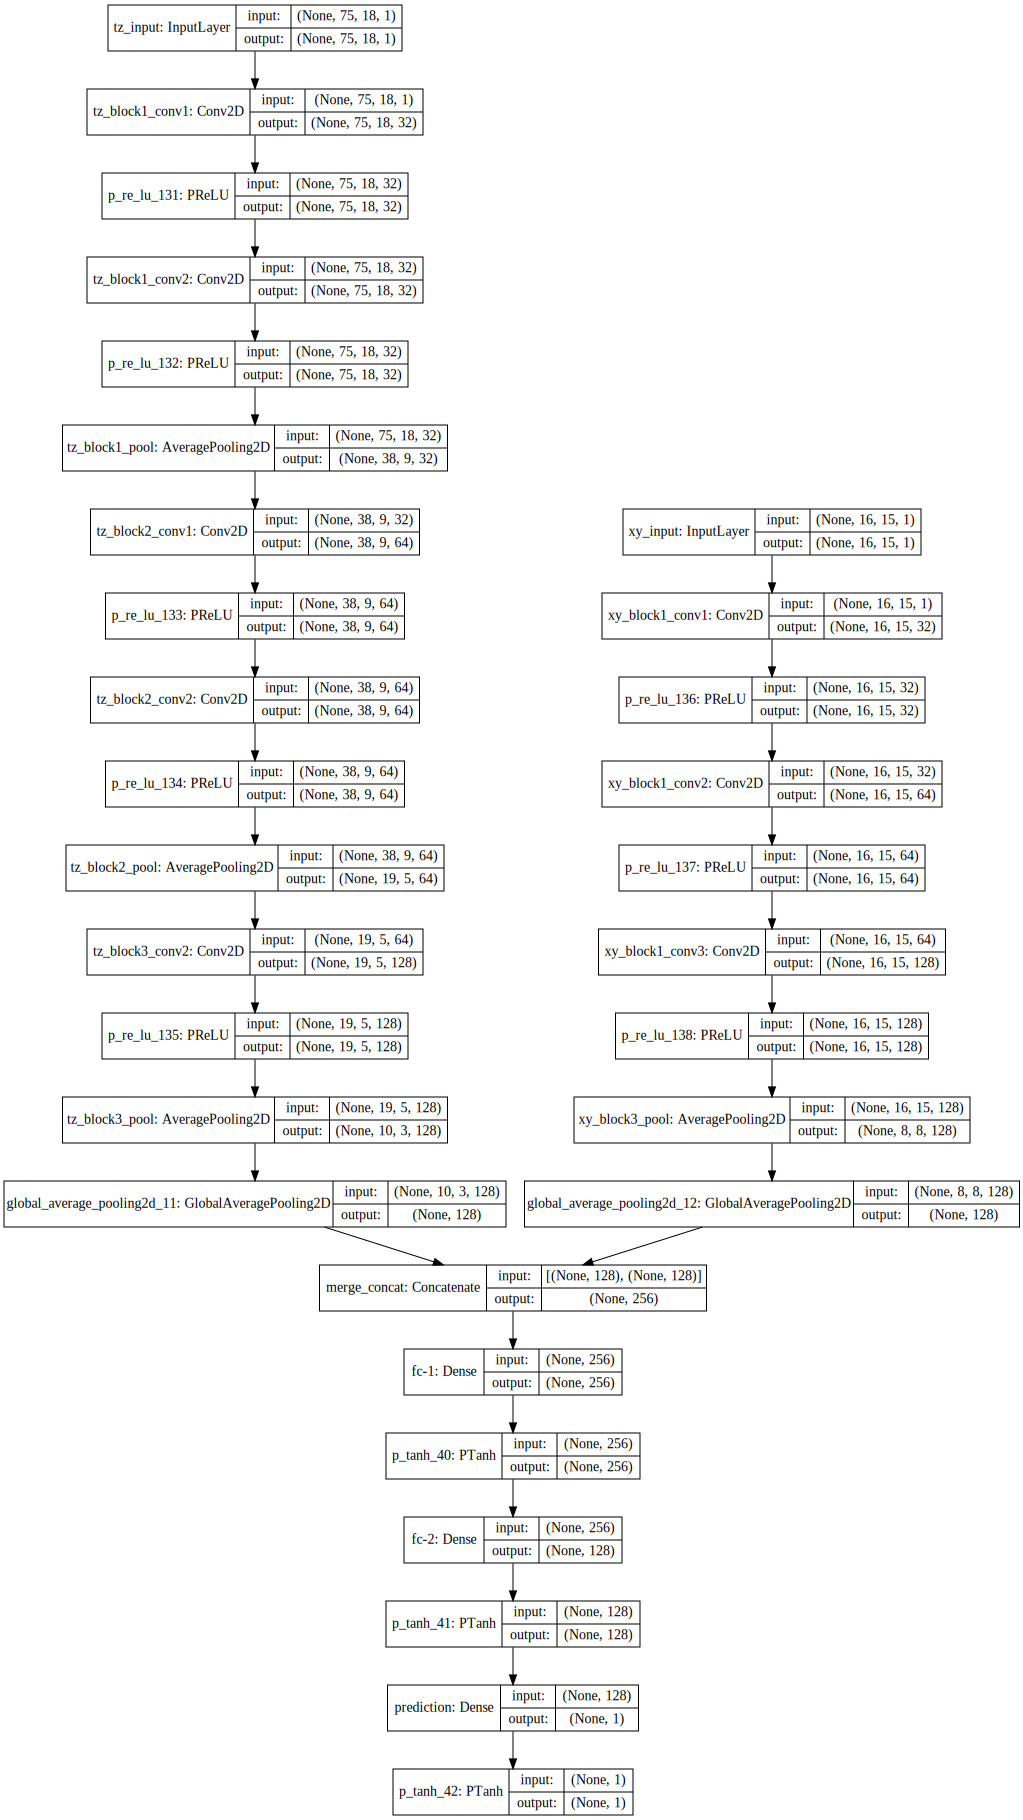

In [42]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))